## CIFAR-10 분류 문제 실습

In [1]:
from functools import reduce
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import batch_norm
from cifar_data import CIFAR10

train_data = CIFAR10(is_train=True)
test_data  = CIFAR10(is_train=False, shuffle=False)

print(train_data.class_names)
print(train_data.X.shape, train_data.y.shape)
print(test_data.X.shape, test_data.y.shape)

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']
(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


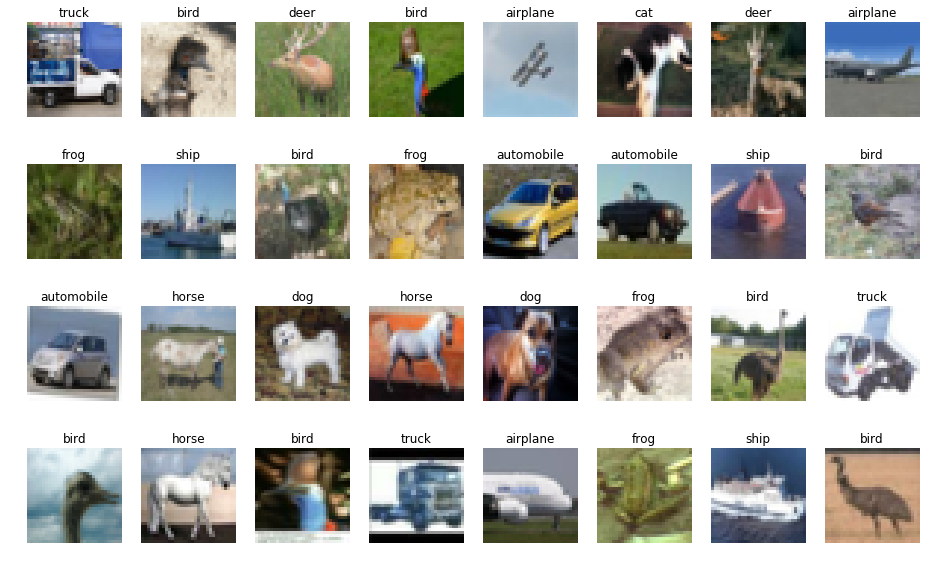

In [2]:
# 샘플 출력 및 시각화
%matplotlib inline
import matplotlib.pyplot as plt

plot_idx = np.random.randint(0, len(train_data.X), 32)

plot_images = train_data.X[plot_idx]
plot_labels = train_data.y[plot_idx]

fig = plt.figure(figsize=(16, 10))
for i, (img, label) in enumerate(zip(plot_images, plot_labels)):
    a = fig.add_subplot(4, 8, i+1)
    a.axis("off")
    a.set_title(train_data.class_names[label])
    plt.imshow(img)

In [3]:
import tensorflow.contrib.layers as layers
he_init = layers.variance_scaling_initializer()

learning_rate = 0.01

inputs = tf.placeholder(tf.float32, [None, 32, 32, 3])
label  = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def conv(inputs, num_filter, ksize, stride, padding, is_training, scope=None):
    bottom_shape = inputs.get_shape().as_list()[3]
    
    with tf.variable_scope(scope):
        W = tf.get_variable("W", [ksize, ksize, bottom_shape, num_filter],
                            initializer=he_init)
        
        x = tf.nn.conv2d(inputs, W, strides=[1, stride, stride, 1],
                         padding=padding)
        x = layers.batch_norm(x, is_training=is_training,
                              decay=0.9, updates_collections=None)
        x = tf.nn.relu(x)
        
    return x

def maxpool(inputs, ksize, stride, padding, scope=None):
    with tf.variable_scope(scope):
        pool = tf.nn.max_pool(inputs, ksize=[1, ksize, ksize, 1],
                              strides=[1, stride, stride, 1],
                              padding=padding)
    return pool
    
def fc(inputs, num_dims, scope=None):
    bottom_shape = inputs.get_shape().as_list()
    if len(bottom_shape) > 2:
        inputs = tf.reshape(inputs,
                            [-1, reduce(lambda x, y: x*y, bottom_shape[1:])])
        bottom_shape = inputs.get_shape().as_list()
        
    with tf.variable_scope(scope):
        W = tf.get_variable("W", [bottom_shape[1], num_dims],
                            initializer=he_init)
        b = tf.get_variable("b", [num_dims],
                            initializer=tf.constant_initializer(0))
        
        out = tf.matmul(inputs, W) + b
    return out
        
def fc_relu(inputs, num_dims, is_training, scope=None):
    with tf.variable_scope(scope):
        out = fc(inputs, num_dims, scope="fc")
        bn  = layers.batch_norm(out, is_training=is_training,
                                decay=0.9, updates_collections=None)
        relu = tf.nn.relu(bn)
    return relu

In [4]:
conv1 = conv(inputs, 32, ksize=3, stride=1, 
             padding="SAME", is_training=is_training, scope="conv1")
conv1 = maxpool(conv1, ksize=2, stride=2, 
                padding="SAME", scope="pool1")

conv2 = conv(conv1, 32, ksize=3, stride=1, 
             padding="SAME", is_training=is_training, scope="conv2")
conv2 = maxpool(conv2, ksize=2, stride=2, 
                padding="SAME", scope="pool2")

conv3 = conv(conv2, 32, ksize=3, stride=1, 
             padding="SAME", is_training=is_training, scope="conv3")
conv3 = maxpool(conv3, ksize=2, stride=2, 
                padding="SAME", scope="pool3")

fc1   = fc_relu(conv3, 128, is_training=is_training, scope="fc1")
logit = fc(fc1, 10, scope="logit")

In [5]:
# 테스트 시 사용하는 연산 그래프 정의
pred_op = tf.nn.softmax(logit)
correct = tf.equal(label, tf.argmax(pred_op, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit))
opt = tf.train.AdamOptimizer(learning_rate).minimize(loss_op)

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

for step in range(100000):
    batch_X, batch_y = train_data.next_batch(128)
    _, loss = sess.run([opt, loss_op], feed_dict={inputs: batch_X, label:batch_y, is_training: True})
    
    if (step+1) % 5000 == 0:
        print(step+1, loss)
    
acc_test = sess.run(accuracy,
    feed_dict={inputs:test_data.X, label:test_data.y, is_training: False})
print("step", step+1, "test_accuracy:", acc_test)

5000 0.328129
10000 0.141224
15000 0.095134
20000 0.0248167
25000 0.0853538
30000 0.0262671
35000 0.00793362
40000 0.0215883
45000 0.0290342
50000 0.0269538
55000 0.00898036
60000 0.024254
65000 0.0205481
70000 0.00790699
75000 0.0193594
80000 0.00443272
85000 0.0282167
90000 0.0298272
95000 0.0250376
100000 0.0118692
step 100000 test_accuracy: 0.7437


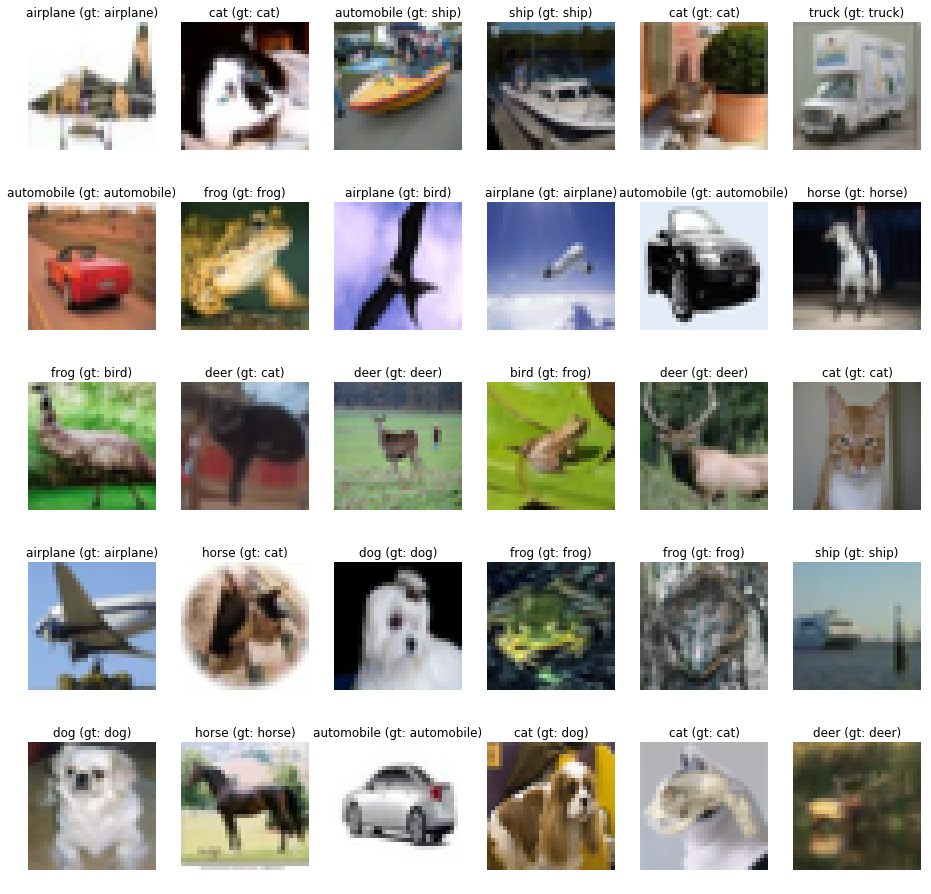

In [6]:
# 테스트 샘플 출력 및 시각화
%matplotlib inline
import matplotlib.pyplot as plt

plot_idx = np.random.randint(0, len(test_data.X), 30)

plot_images = test_data.X[plot_idx]
plot_labels = test_data.y[plot_idx]

plot_preds = sess.run(pred_op, feed_dict={inputs:plot_images, is_training:False})
plot_preds = np.argmax(plot_preds, axis=1)

fig = plt.figure(figsize=(16, 16))
for i, (img, label, pred) in enumerate(zip(plot_images, plot_labels, plot_preds)):
    a = fig.add_subplot(5, 6, i+1)
    a.set_title("{} (gt: {})".format(train_data.class_names[pred], train_data.class_names[label]))
    a.axis("off")
    plt.imshow(img)